In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
%matplotlib inline

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")

    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 18, alternate_sign=False, ngram_range=(1,2))
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
    
    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    ### here are my customized features
    # use KBinsDiscretizer to discretize quantitative features
    if(not test):
        est = KBinsDiscretizer(n_bins=[4, 3], encode='onehot', strategy='kmeans')
        X_dis = est.fit_transform(X_quant_features)
        fitted_transformations.append(est)
    else:
        X_dis = fitted_transformations[2].transform(X_quant_features)
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_dis])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[3].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X, y, X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_all, y_all, X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../moviereviews_train.tsv', my_random_seed=713)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 262144)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9
5          89           5
6         112           9
7         132           9
8         163           7
9          43           5
Size of combined bag of words and new quantitative variables matrix:
(25000, 262151)
(25000, 262151)
Shape of X_train and X_test:
(20000, 262151)
(5000, 262151)
Shape of y_train and y_test:
(20000,)
(5000,)
Shape of X_raw_train and X_raw_test:
(20000, 5)
(5000, 5)
SUCCESS!
Number of fits stored in `fitted_transformations` list: 
4


# Fit (and tune) Various Models

### MODEL: SVM, linear

In [5]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9996, 'Neg': 10004, 'TP': 9996, 'TN': 10004, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: Ridge Regression Classifier

In [6]:
from sklearn import linear_model

rdg_alphas = [1, 5, 40, 320, 2560, 5120]

In [7]:
# Cross Validation
rdg_0 = linear_model.RidgeClassifier(alpha=rdg_alphas[0])
rdg_0_scores = cross_val_score(rdg_0, X_all, y_all, cv=5)
print("%0.6f accuracy with a standard deviation of %0.6f" % (rdg_0_scores.mean(), rdg_0_scores.std()))

rdg_1 = linear_model.RidgeClassifier(alpha=rdg_alphas[1])
rdg_1_scores = cross_val_score(rdg_1, X_all, y_all, cv=5)
print("%0.6f accuracy with a standard deviation of %0.6f" % (rdg_1_scores.mean(), rdg_1_scores.std()))

rdg_2 = linear_model.RidgeClassifier(alpha=rdg_alphas[2])
rdg_2_scores = cross_val_score(rdg_2, X_all, y_all, cv=5)
print("%0.6f accuracy with a standard deviation of %0.6f" % (rdg_2_scores.mean(), rdg_2_scores.std()))

rdg_3 = linear_model.RidgeClassifier(alpha=rdg_alphas[3])
rdg_3_scores = cross_val_score(rdg_3, X_all, y_all, cv=5)
print("%0.6f accuracy with a standard deviation of %0.6f" % (rdg_3_scores.mean(), rdg_3_scores.std()))

rdg_4 = linear_model.RidgeClassifier(alpha=rdg_alphas[4])
rdg_4_scores = cross_val_score(rdg_4, X_all, y_all, cv=5)
print("%0.6f accuracy with a standard deviation of %0.6f" % (rdg_4_scores.mean(), rdg_4_scores.std()))

rdg_5 = linear_model.RidgeClassifier(alpha=rdg_alphas[5])
rdg_5_scores = cross_val_score(rdg_5, X_all, y_all, cv=5)
print("%0.6f accuracy with a standard deviation of %0.6f" % (rdg_5_scores.mean(), rdg_5_scores.std()))

0.882720 accuracy with a standard deviation of 0.005959
0.882720 accuracy with a standard deviation of 0.005959
0.882720 accuracy with a standard deviation of 0.005959
0.882680 accuracy with a standard deviation of 0.005974
0.883200 accuracy with a standard deviation of 0.005781
0.883720 accuracy with a standard deviation of 0.005700


In [8]:

rdg_0.fit(X_train, y_train)
rdg_0_performance_train = BinaryClassificationPerformance(rdg_0.predict(X_train), y_train, 'rdg_train_0('+ str(rdg_alphas[0]) + ')')
rdg_0_performance_train.compute_measures()
print("Ridge Regression 0 (alpha="+ str(rdg_alphas[0]) +"):")
print(rdg_0_performance_train.performance_measures)

rdg_1.fit(X_train, y_train)
rdg_1_performance_train = BinaryClassificationPerformance(rdg_1.predict(X_train), y_train, 'rdg_train_1('+ str(rdg_alphas[1]) + ')')
rdg_1_performance_train.compute_measures()
print("Ridge Regression 1 (alpha="+ str(rdg_alphas[1]) +"):")
print(rdg_1_performance_train.performance_measures)

rdg_2.fit(X_train, y_train)
rdg_2_performance_train = BinaryClassificationPerformance(rdg_2.predict(X_train), y_train, 'rdg_train_2('+ str(rdg_alphas[2]) + ')')
rdg_2_performance_train.compute_measures()
print("Ridge Regression 2 (alpha="+ str(rdg_alphas[2]) +"):")
print(rdg_2_performance_train.performance_measures)

rdg_3.fit(X_train, y_train)
rdg_3_performance_train = BinaryClassificationPerformance(rdg_3.predict(X_train), y_train, 'rdg_train_3('+ str(rdg_alphas[3]) + ')')
rdg_3_performance_train.compute_measures()
print("Ridge Regression 3 (alpha="+ str(rdg_alphas[3]) +"):")
print(rdg_3_performance_train.performance_measures)

rdg_4.fit(X_train, y_train)
rdg_4_performance_train = BinaryClassificationPerformance(rdg_4.predict(X_train), y_train, 'rdg_train_4('+ str(rdg_alphas[4]) + ')')
rdg_4_performance_train.compute_measures()
print("Ridge Regression 4 (alpha="+ str(rdg_alphas[4]) +"):")
print(rdg_4_performance_train.performance_measures)

rdg_5.fit(X_train, y_train)
rdg_5_performance_train = BinaryClassificationPerformance(rdg_5.predict(X_train), y_train, 'rdg_train_5('+ str(rdg_alphas[5]) + ')')
rdg_5_performance_train.compute_measures()
print("Ridge Regression 5 (alpha="+ str(rdg_alphas[5]) +"):")
print(rdg_5_performance_train.performance_measures)

Ridge Regression 0 (alpha=1):
{'Pos': 9996, 'Neg': 10004, 'TP': 9996, 'TN': 10004, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train_0(1)'}
Ridge Regression 1 (alpha=5):
{'Pos': 9996, 'Neg': 10004, 'TP': 9996, 'TN': 10004, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train_1(5)'}
Ridge Regression 2 (alpha=40):
{'Pos': 9996, 'Neg': 10004, 'TP': 9996, 'TN': 10004, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train_2(40)'}
Ridge Regression 3 (alpha=320):
{'Pos': 9996, 'Neg': 10004, 'TP': 9996, 'TN': 10004, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train_3(320)'}
Ridge Regression 4 (alpha=2560):
{'Pos': 9996, 'Neg': 10004, 'TP': 9996, 'TN': 10004, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train_4(2560)'}
Ridge Regression 5 (alpha=5120):
{'Pos': 9996, 'Neg': 10004, 'TP': 9996, 'TN': 10004, 'FP': 0, 'FN': 0,

### ROC plot to compare performance of various models and fits

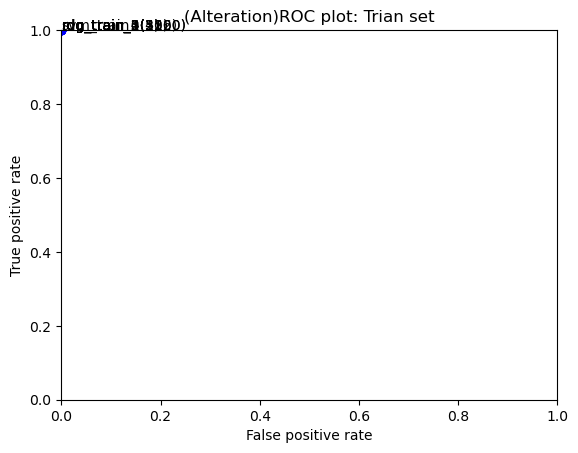

In [9]:
fits = [svm_performance_train, rdg_0_performance_train, rdg_1_performance_train, rdg_2_performance_train, rdg_3_performance_train, rdg_4_performance_train, rdg_5_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('(Alteration)ROC plot: Trian set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# Look at performance on the test set

### MODEL: SVM, linear

In [10]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2504, 'Neg': 2496, 'TP': 2069, 'TN': 2064, 'FP': 432, 'FN': 435, 'Accuracy': 0.8266, 'Precision': 0.8272690923630548, 'Recall': 0.8262779552715654, 'desc': 'svm_test'}


### MODEL: Ridge Regression Classifier

In [11]:
rdg_0_performance_test = BinaryClassificationPerformance(rdg_0.predict(X_test), y_test, 'rdg_test_0('+ str(rdg_alphas[0]) + ')')
rdg_0_performance_test.compute_measures()
print(rdg_0_performance_test.performance_measures)

rdg_1_performance_test = BinaryClassificationPerformance(rdg_1.predict(X_test), y_test, 'rdg_test_1('+ str(rdg_alphas[1]) + ')')
rdg_1_performance_test.compute_measures()
print(rdg_1_performance_test.performance_measures)

rdg_2_performance_test = BinaryClassificationPerformance(rdg_2.predict(X_test), y_test, 'rdg_test_2('+ str(rdg_alphas[2]) + ')')
rdg_2_performance_test.compute_measures()
print(rdg_2_performance_test.performance_measures)

rdg_3_performance_test = BinaryClassificationPerformance(rdg_3.predict(X_test), y_test, 'rdg_test_3('+ str(rdg_alphas[3]) + ')')
rdg_3_performance_test.compute_measures()
print(rdg_3_performance_test.performance_measures)

rdg_4_performance_test = BinaryClassificationPerformance(rdg_4.predict(X_test), y_test, 'rdg_test_4('+ str(rdg_alphas[4]) + ')')
rdg_4_performance_test.compute_measures()
print(rdg_4_performance_test.performance_measures)

rdg_5_performance_test = BinaryClassificationPerformance(rdg_5.predict(X_test), y_test, 'rdg_test_5('+ str(rdg_alphas[5]) + ')')
rdg_5_performance_test.compute_measures()
print(rdg_5_performance_test.performance_measures)

{'Pos': 2504, 'Neg': 2496, 'TP': 2244, 'TN': 2174, 'FP': 322, 'FN': 260, 'Accuracy': 0.8836, 'Precision': 0.8745128604832424, 'Recall': 0.8961661341853036, 'desc': 'rdg_test_0(1)'}
{'Pos': 2504, 'Neg': 2496, 'TP': 2244, 'TN': 2174, 'FP': 322, 'FN': 260, 'Accuracy': 0.8836, 'Precision': 0.8745128604832424, 'Recall': 0.8961661341853036, 'desc': 'rdg_test_1(5)'}
{'Pos': 2504, 'Neg': 2496, 'TP': 2244, 'TN': 2174, 'FP': 322, 'FN': 260, 'Accuracy': 0.8836, 'Precision': 0.8745128604832424, 'Recall': 0.8961661341853036, 'desc': 'rdg_test_2(40)'}
{'Pos': 2504, 'Neg': 2496, 'TP': 2244, 'TN': 2174, 'FP': 322, 'FN': 260, 'Accuracy': 0.8836, 'Precision': 0.8745128604832424, 'Recall': 0.8961661341853036, 'desc': 'rdg_test_3(320)'}
{'Pos': 2504, 'Neg': 2496, 'TP': 2245, 'TN': 2175, 'FP': 321, 'FN': 259, 'Accuracy': 0.884, 'Precision': 0.8749025720966485, 'Recall': 0.8965654952076677, 'desc': 'rdg_test_4(2560)'}
{'Pos': 2504, 'Neg': 2496, 'TP': 2245, 'TN': 2175, 'FP': 321, 'FN': 259, 'Accuracy': 0.884

### ROC plot to compare performance of various models and fits

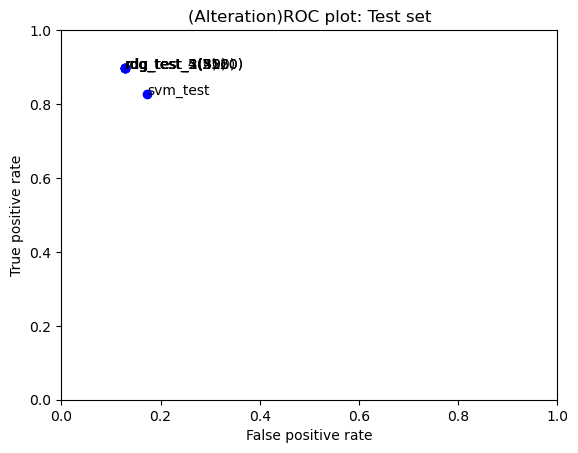

In [12]:
fits = [svm_performance_test, rdg_1_performance_test, rdg_2_performance_test, rdg_3_performance_test, rdg_4_performance_test, rdg_5_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('(Alteration)ROC plot: Test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# <span style="color:red">SUBMISSION</span>

In [20]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='../moviereviews_test.tsv', my_random_seed=713, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

Shape of HashingVectorizer X:
(25000, 262144)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size of combined bag of words and new quantitative variables matrix:
(25000, 262151)
(25000, 262151)
Shape of X_test for submission:
(25000, 262151)
SUCCESS!
Number of rows in the submission test set (should be 25,000): 


In [14]:
# I am choosing the Ridge Regression Classifier model(alpha=5120) fit, which is in the `rdg` object.

In [21]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["Prediction"] = rdg_5.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['Prediction'].mean())

0.4972


In [22]:
raw_data.head(5)

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [23]:
my_submission.head(5)

,id,Prediction
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,0
4,12128_7,1


In [24]:
my_submission.shape

(25000, 2)

In [25]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('moviereviews_submission_2nd.csv', index=False)